# Проект: Телекоммуникации

## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

__Описание услуг компании__

Оператор предоставляет два основных типа услуг: 

* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

### Цель исследования

Минимизировать отток клиентов в компании «ТелеДом»

### Задачи исследования

Обучить модель предсказания разорвет ли абонент договор

### Исходные данные

* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

### План исследования

2. Подключение библиотек
3. Загрузка данных
4. Предобработка данных
5. Исследовательский анализ данных
6. Отбор признаков
7. Предобработка объединенных данных
8. Исследовательский анализ объединенных данных
9. Корреляционный анализ
10. Подготовка данных
11. Обучение моделей
12. Выбор лучшей модели
13. Вывод и рекомендации

## Подключение библиотек

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, classification_report

from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings("ignore")

## Загрузка данных

In [3]:
RANDOM_STATE = 141024

In [4]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv') 
phone = pd.read_csv('/datasets/phone_new.csv') 

In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Таблица contract содержит информацию об абонентах, их договорах и платежах. В ней отражены сроки действия договоров, типы оплаты и способы выставления счетов. Также представлены данные о ежемесячных расходах и общих затратах за весь период использования услуг.

In [6]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Таблица personal содержит информацию о пользователях и их демографических характеристиках. В ней представлены данные о поле, семейном положении и наличии детей.

In [7]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Таблица internet содержит информацию об услугах, подключенных пользователями. В ней указаны тип интернет-соединения и наличие дополнительных сервисов, таких как блокировка опасных сайтов, облачное хранилище, антивирус, техническая поддержка, а также доступ к стриминговому телевидению и фильмам.

In [8]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Таблица phone содержит информацию о пользователях и наличии у них услуги подключения телефона к нескольким линиям.

## Предобработка данных

### Целевой признак

Сформируем целевой признак по столбцу EndDate:
* 0 - клиент ушел
* 1 - текущий клиент

In [9]:
y = contract['EndDate'].apply(lambda x: 1 if x == 'No' else 0).tolist()

### Пропуски

In [10]:
def passes(df):
    columns = df.columns
    for col in columns:
        print(f'{col}: {df[col].isna().sum()}')

In [11]:
contract.replace(' ', np.nan, inplace=True)

In [12]:
passes(contract)

customerID: 0
BeginDate: 0
EndDate: 0
Type: 0
PaperlessBilling: 0
PaymentMethod: 0
MonthlyCharges: 0
TotalCharges: 11


In [13]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(contract['MonthlyCharges'])

In [14]:
passes(contract)

customerID: 0
BeginDate: 0
EndDate: 0
Type: 0
PaperlessBilling: 0
PaymentMethod: 0
MonthlyCharges: 0
TotalCharges: 0


В столбцe TotalCharges найдены пустые строки. Они заполнены значением столбца MonthlyCharges, так как если значение в TotalCharges отсутствует, но есть данные о ежемесячной плате, можно предположить, что клиент только начал пользоваться услугами, и общая сумма на данный момент равна сумме за первый месяц, то есть TotalCharges ≈ MonthlyCharges.

In [15]:
passes(contract)

customerID: 0
BeginDate: 0
EndDate: 0
Type: 0
PaperlessBilling: 0
PaymentMethod: 0
MonthlyCharges: 0
TotalCharges: 0


In [16]:
passes(personal)

customerID: 0
gender: 0
SeniorCitizen: 0
Partner: 0
Dependents: 0


In [17]:
passes(internet)

customerID: 0
InternetService: 0
OnlineSecurity: 0
OnlineBackup: 0
DeviceProtection: 0
TechSupport: 0
StreamingTV: 0
StreamingMovies: 0


In [18]:
passes(phone)

customerID: 0
MultipleLines: 0


### Типы данных

In [19]:
contract.dtypes

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

In [20]:
contract.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04


In [21]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = contract['EndDate'].replace('No', '2020-02-01')
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [22]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [23]:
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

In [24]:
contract.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
dtype: object

In [25]:
personal.dtypes

customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

In [26]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('object')

In [27]:
personal.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No


In [28]:
internet.dtypes

customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

In [29]:
internet.head(1)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No


In [30]:
phone.dtypes

customerID       object
MultipleLines    object
dtype: object

In [31]:
phone.head(1)

,customerID,MultipleLines
0,5575-GNVDE,No


### Дубликаты

In [32]:
def duplicates(df):
    columns = df.columns
    print(f'Количество явных дубликатов: {df.duplicated().sum()}')
    for col in columns:
        print(f'{col}: {df[col].unique()}')

In [33]:
duplicates(contract)

Количество явных дубликатов: 0
customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
BeginDate: ['2020-01-01T00:00:00.000000000' '2017-04-01T00:00:00.000000000'
 '2019-10-01T00:00:00.000000000' '2016-05-01T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-03-01T00:00:00.000000000'
 '2018-04-01T00:00:00.000000000' '2019-04-01T00:00:00.000000000'
 '2017-07-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2019-01-01T00:00:00.000000000' '2018-10-01T00:00:00.000000000'
 '2015-04-01T00:00:00.000000000' '2015-09-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2014-05-01T00:00:00.000000000'
 '2015-10-01T00:00:00.000000000' '2014-03-01T00:00:00.000000000'
 '2018-05-01T00:00:00.000000000' '2019-11-01T00:00:00.000000000'
 '2019-02-01T00:00:00.000000000' '2016-01-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2014-02-01T00:00:00.000000000' '2018-06-01T00:00:00.000000000'
 '2019-12-01T00:

In [34]:
duplicates(personal)

Количество явных дубликатов: 0
customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']


In [35]:
duplicates(internet)

Количество явных дубликатов: 0
customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
InternetService: ['DSL' 'Fiber optic']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']


In [36]:
duplicates(phone)

Количество явных дубликатов: 0
customerID: ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
MultipleLines: ['No' 'Yes']


### Вывод

В этом разделе выполнили первичную предобработку данных. В столбце с общими расходами было заполнено несколько пропусков. Дубликаты не были найдены. Поменяли типы данных в таблице contract. Также сделали целевой признак для модели. 

## Исследовательский анализ данных

### Построение графиков

In [37]:
def build_hist(df):
    columns = df.select_dtypes(include='number').columns
    for col in columns:
        plt.figure(figsize=(10, 6))
        bins = int(len(df[col]) ** 0.5)
        sns.histplot(df[col].dropna(), color='#af6ac4', kde=False, bins=bins)
        sns.despine()
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

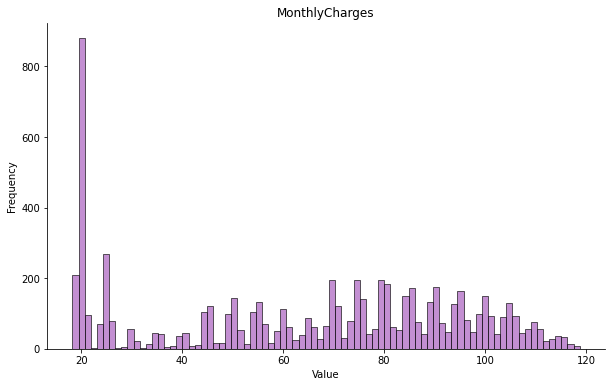

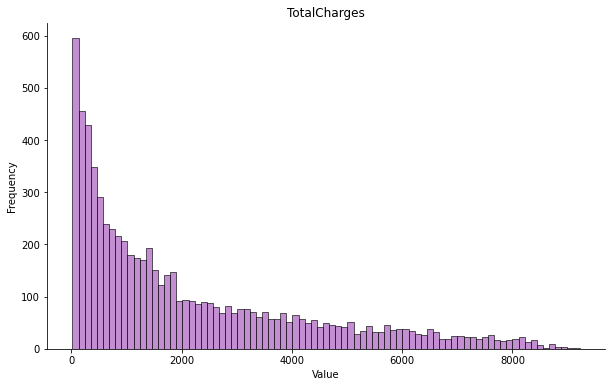

In [38]:
build_hist(contract)

In [39]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.377573
std,30.090047,2112.678861
min,18.250000,19.050000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


Средний ежемесячный платёж составляет около 64.76, а общий — 2112.74. Разброс значений TotalCharges значительно больше, следовательно общая сумма у клиентов довольно вариативная.

In [40]:
def build_plots(df, columns):
    for col in columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x=col, palette='BuPu')
        plt.title(col)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

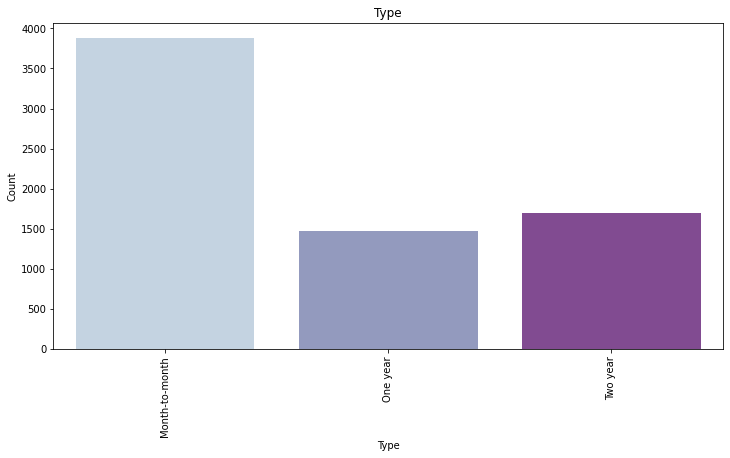

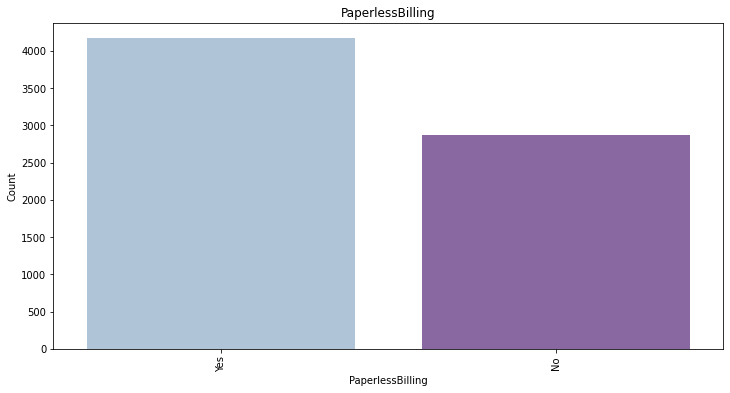

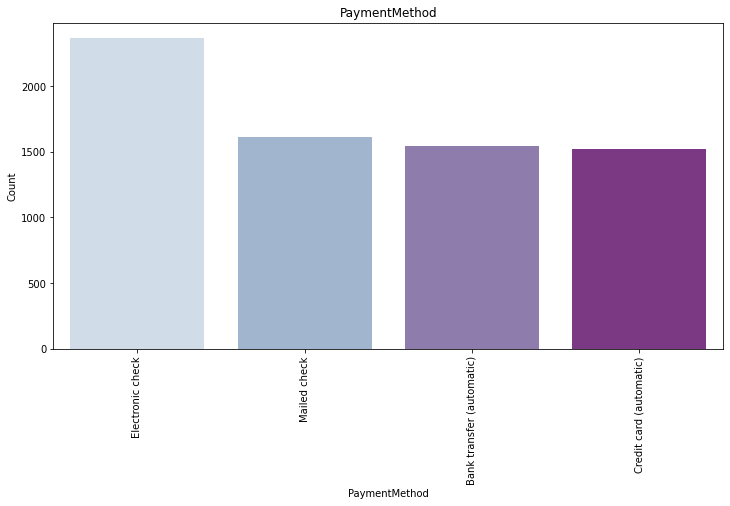

In [41]:
columns = contract.select_dtypes(exclude=['number', 'datetime']).columns.tolist()
columns.remove('customerID')
build_plots(contract, columns)

Большая часть клиентов платит за услуги каждый месяц. Типы платежей пользуются примерно одинаковой популярностью.

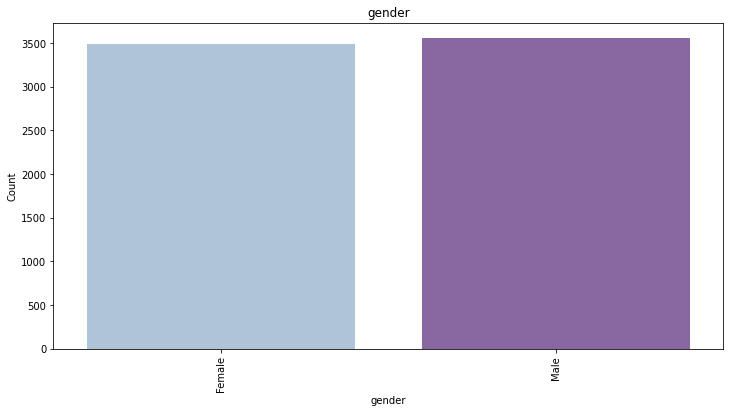

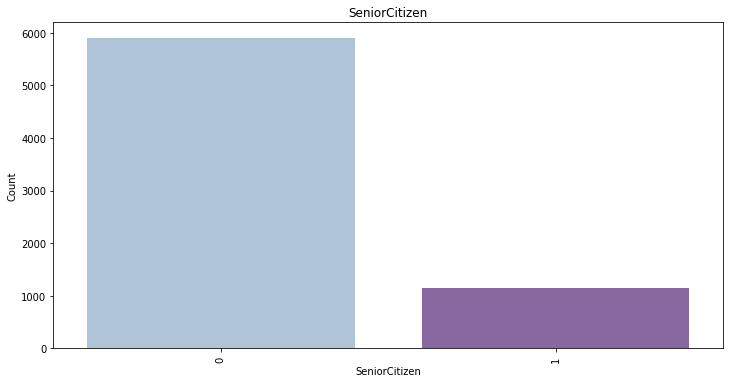

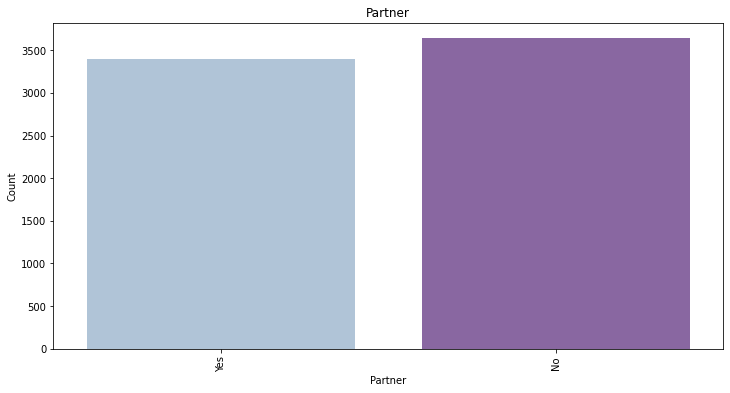

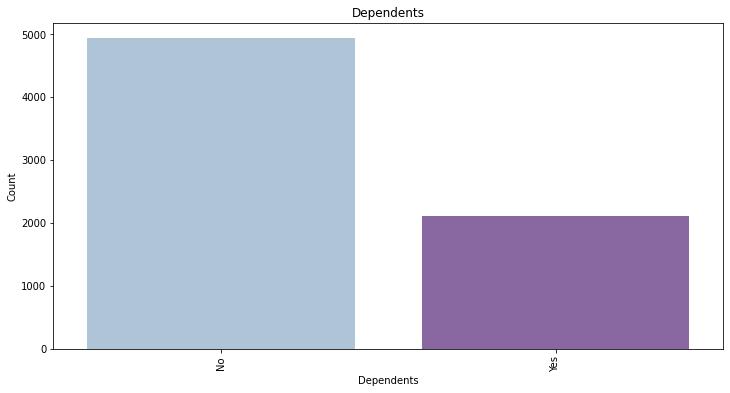

In [42]:
columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
build_plots(personal, columns)

Количество клиентов мужского и женского пола одинаково. Большинство пользователей еще не достигли пенсионного возраста. Количество клиентов с партнёром и без него одинаково. У большинства из них нет детей.

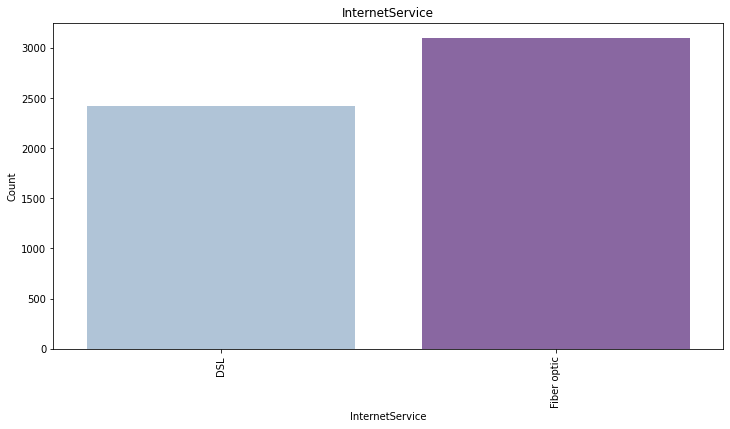

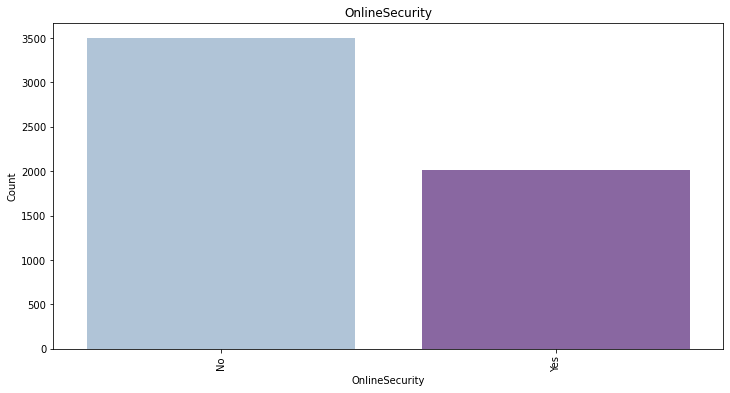

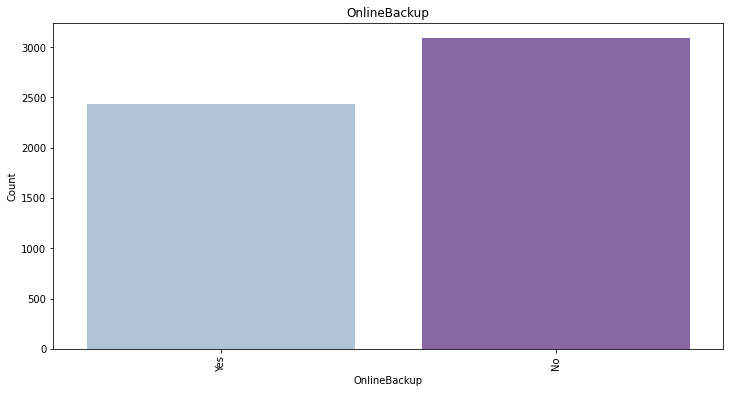

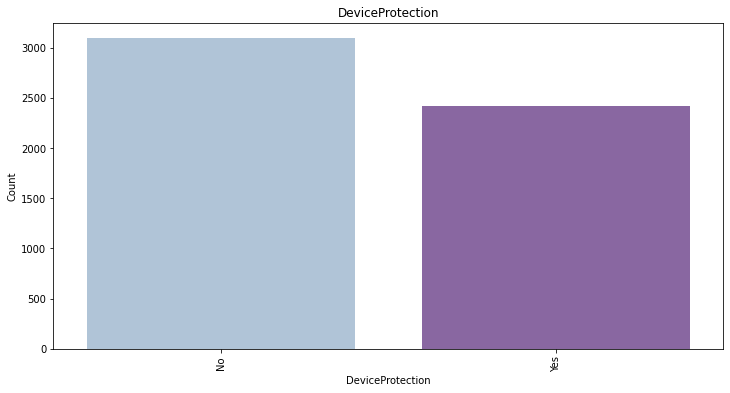

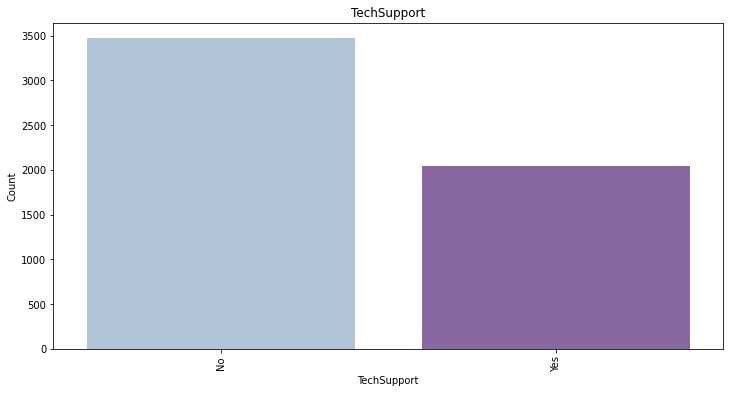

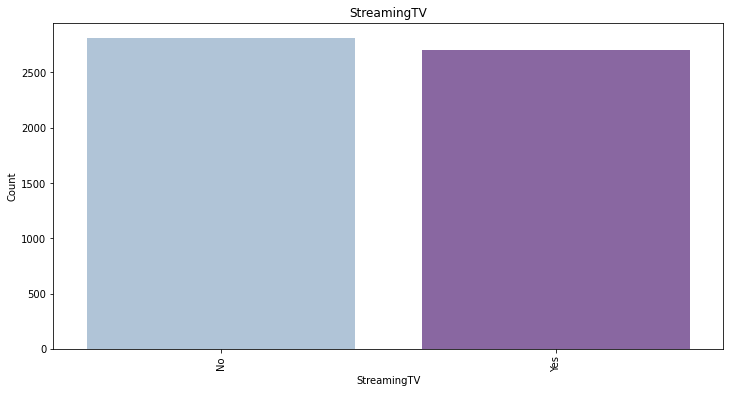

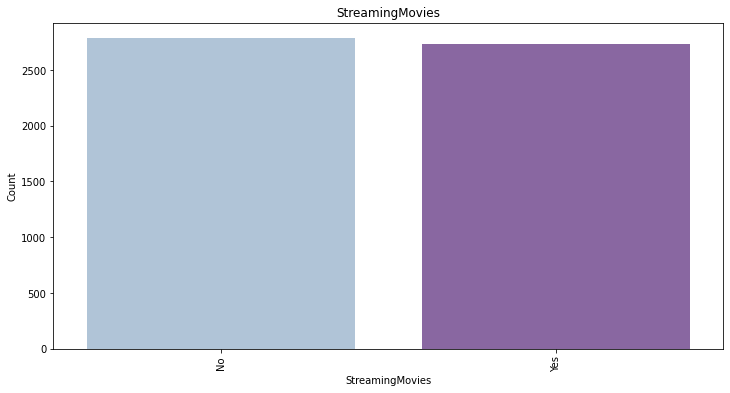

In [43]:
columns = internet.select_dtypes(exclude='number').columns
columns = columns.drop('customerID')
build_plots(internet, columns)

Большинство клиентов не используют блокировку опасных сайтов. Больше половины не применяют облачное хранилище. Мало 
кто использует линию технической поддержки. 

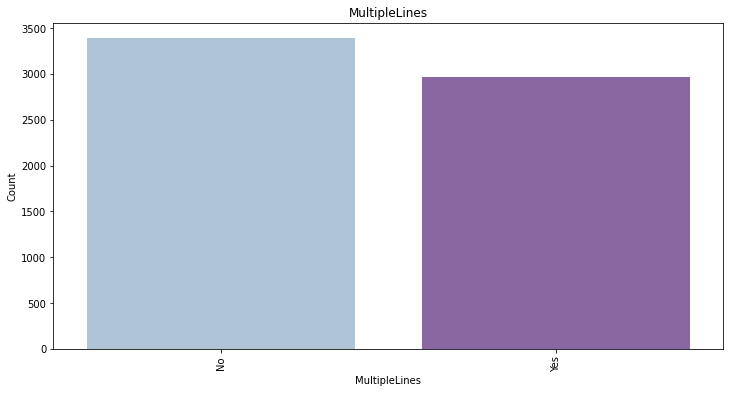

In [44]:
build_plots(phone, ['MultipleLines'])

Больше, чем у половины клиентов телефон подключен к нескольким линиям одновременно

### Вывод

В этом разделе проанализировали графики всех датафреймов. Выделим несколько особенностей:
* Ежемесячные расходы у большинства клиентов минимальны, а общая сумма расходов уменьшается по мере их снижения;
* Большая часть категориальных признаков в равных пропорциях. 

## Отбор признаков

In [45]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50


In [46]:
contract['Lifetime'] = contract['EndDate'] - contract['BeginDate']
contract['Lifetime'] = contract['Lifetime'].dt.days.astype(int)

In [47]:
contract_selected = contract.copy()[['customerID', 'Lifetime', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']]
personal_selected = personal.copy()
internet_selected = internet.copy()
phone_selected = phone.copy()

Не включаем признаки даты начала и окончания контракта, так как они могут привести к проблемам с высокой корреляцией или мультиколлинеарностью. На их основе был создан новый признак - срок контракта

In [48]:
data = pd.merge(contract_selected, personal_selected, on='customerID', how='outer') 
data = data.merge(internet_selected, on='customerID', how='outer') 
data = data.merge(phone_selected, on='customerID', how='outer')

In [49]:
contract_selected.shape, personal_selected.shape, internet_selected.shape, phone_selected.shape, data.shape

((7043, 7), (7043, 5), (5517, 8), (6361, 2), (7043, 19))

In [50]:
data['Status'] = y

## Предобработка объединенных данных

In [51]:
data.head()

,customerID,Lifetime,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Status
0,7590-VHVEG,31,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,1
1,5575-GNVDE,1036,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1
2,3668-QPYBK,123,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,1371,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1
4,9237-HQITU,153,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


### Пропуски

In [52]:
passes(data)

customerID: 0
Lifetime: 0
Type: 0
PaperlessBilling: 0
PaymentMethod: 0
MonthlyCharges: 0
TotalCharges: 0
gender: 0
SeniorCitizen: 0
Partner: 0
Dependents: 0
InternetService: 1526
OnlineSecurity: 1526
OnlineBackup: 1526
DeviceProtection: 1526
TechSupport: 1526
StreamingTV: 1526
StreamingMovies: 1526
MultipleLines: 682
Status: 0


In [53]:
data['TechSupport'].unique()

array(['No', 'Yes', nan], dtype=object)

In [54]:
data = data.fillna('no_package')

Заполним пропуски в бинарных категориальных признаках новым значением - нет пакета. Это связано с тем, что некоторые клиенты имеют только один пакет услуг, и при присоединении они получили пропуски в услугах из другого. 

In [55]:
passes(data)

customerID: 0
Lifetime: 0
Type: 0
PaperlessBilling: 0
PaymentMethod: 0
MonthlyCharges: 0
TotalCharges: 0
gender: 0
SeniorCitizen: 0
Partner: 0
Dependents: 0
InternetService: 0
OnlineSecurity: 0
OnlineBackup: 0
DeviceProtection: 0
TechSupport: 0
StreamingTV: 0
StreamingMovies: 0
MultipleLines: 0
Status: 0


### Типы данных

In [56]:
data.dtypes

customerID           object
Lifetime              int64
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
Status                int64
dtype: object

In [57]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

In [58]:
data.head(1)

,customerID,Lifetime,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Status
0,7590-VHVEG,31,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_package,1


### Дубликаты

In [59]:
duplicates(data)

Количество явных дубликатов: 0
customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Lifetime: [  31 1036  123 1371  153  337  671  306  945  882  396  488 1767 1614
  761  670 1584 2163  641   92  365 1492 1523 2191  610 1706   62  822
 1764  245 1401 1095  427 1948  518 1918 2102 1310 1826  580 2010 1432
 1246  549 1949 1888  914 1279  276 1067 1461  883  881  792 1157 1581
 1280  973 1248  184  215 1006  853 2041  702 1737 1857 1979  457  884
 1431  485 1034  975 1551  700  942 1734 1798  730 1340 1216  943 1066
 1096 1645 1642  273 1553 1219  303 1126 1887 2071  426 2040  911 2132
 1736  640 1489 1675 1218 1522 1186  608  214   59   61    0 1035 1341
 1917 1676 1795 1155  913  182  820 1430  976  579  669  486  668  760
 1611  912 1552  275 2038 1187 1068 1003 1127 1124  274 1705  305 1308
 1491  762  335 1185  425  609 1004 2283 1005  181  489  304 1247 1065
  550  854 2070 1370  334  213  122  851  395  546  578  548  946  638
 1007  456

## Исследовательский анализ объединенных данных

### Построение графиков

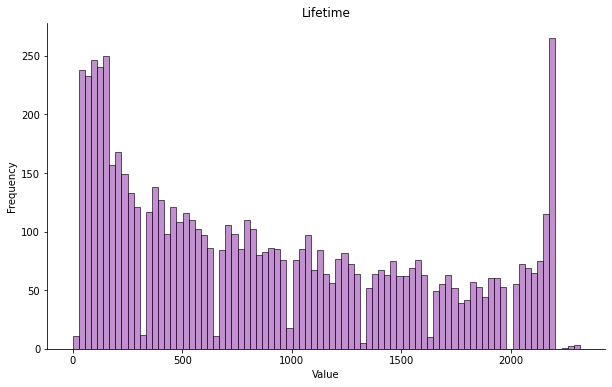

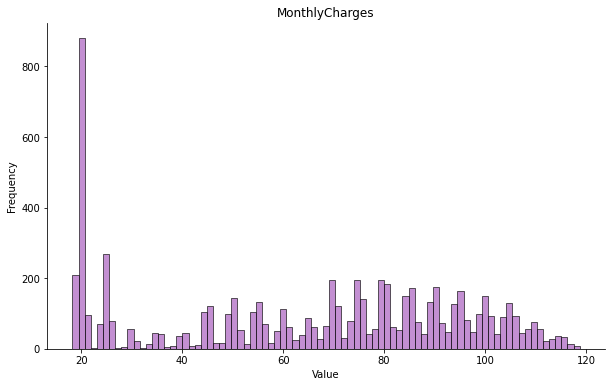

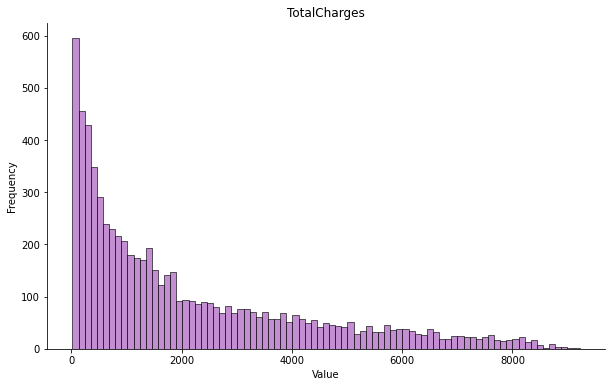

In [60]:
data_hist = data.drop(['Status'], axis=1)
build_hist(data_hist)

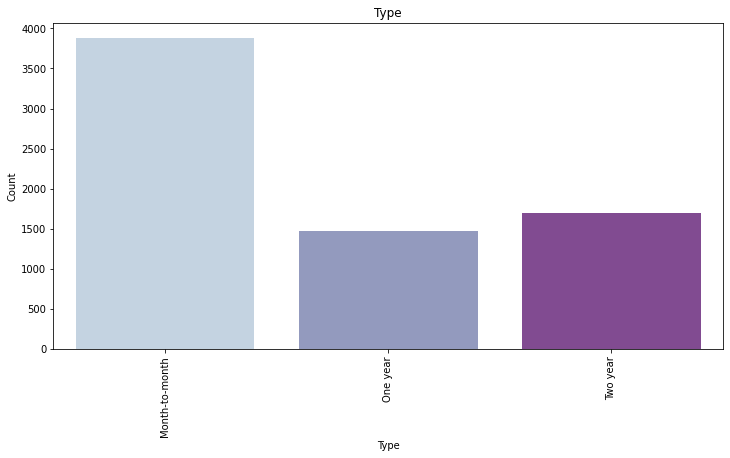

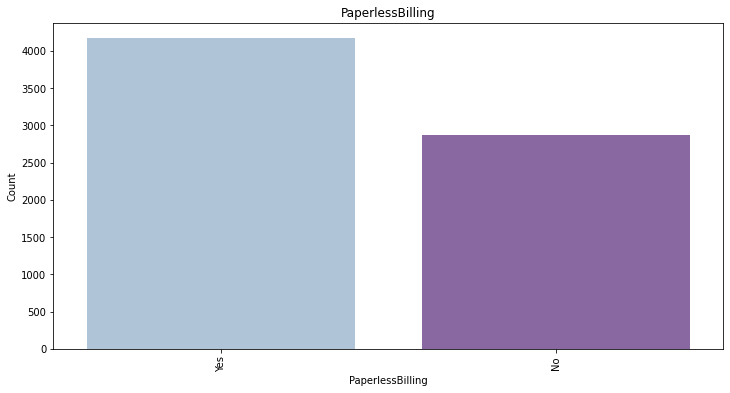

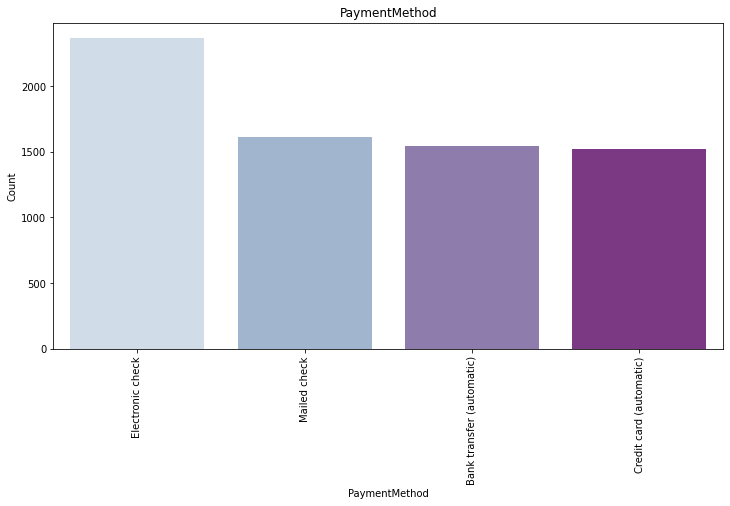

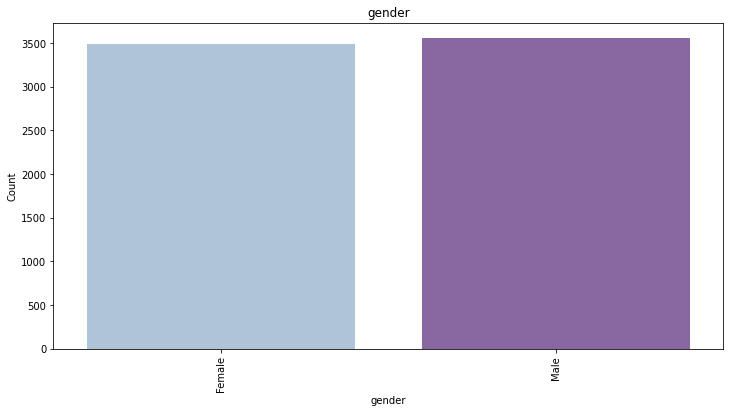

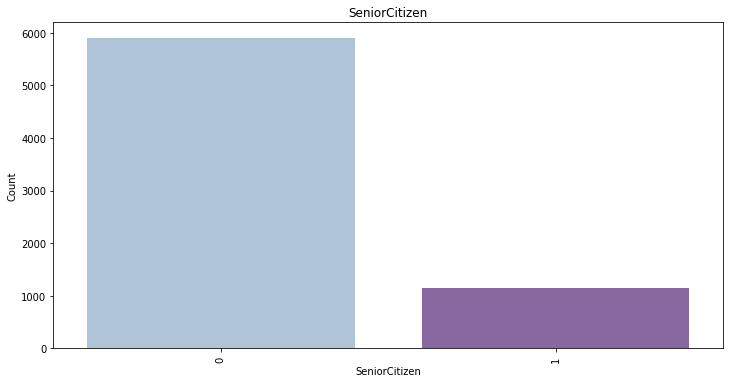

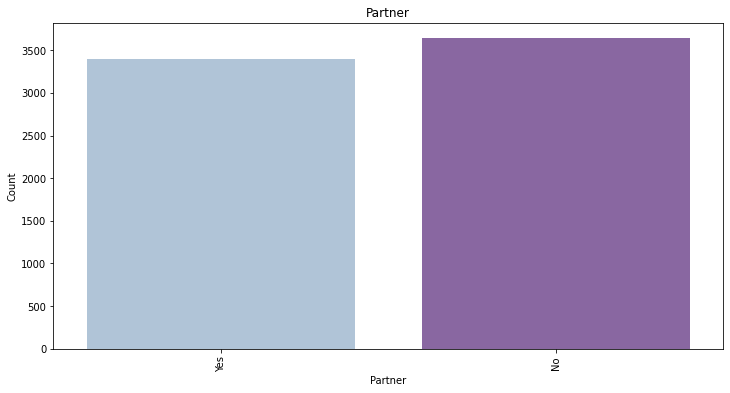

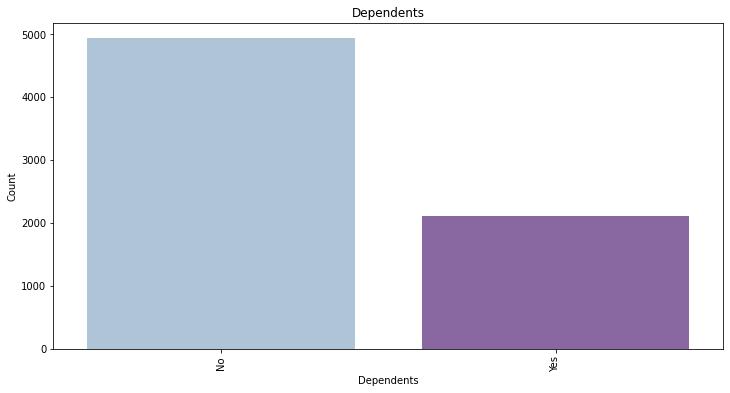

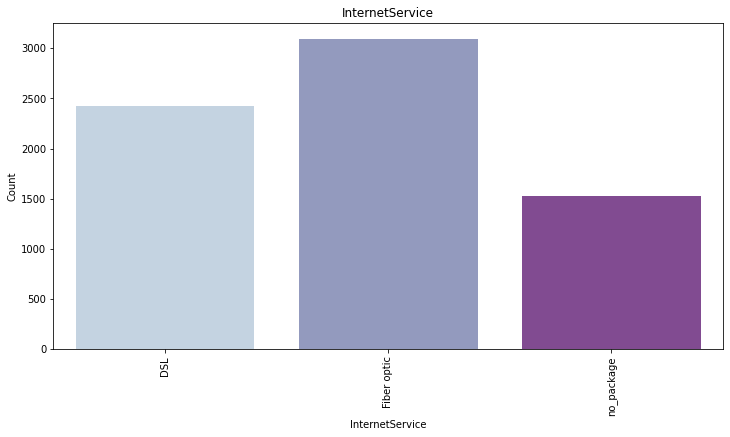

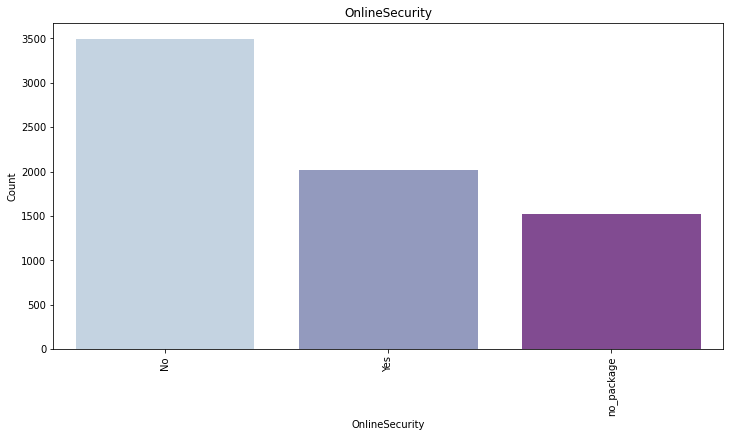

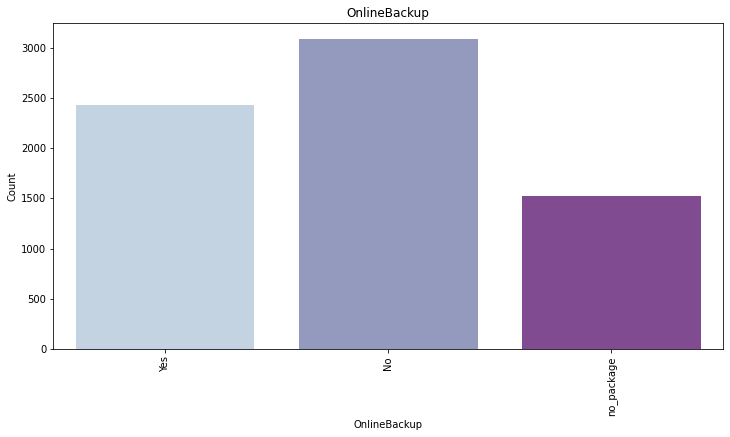

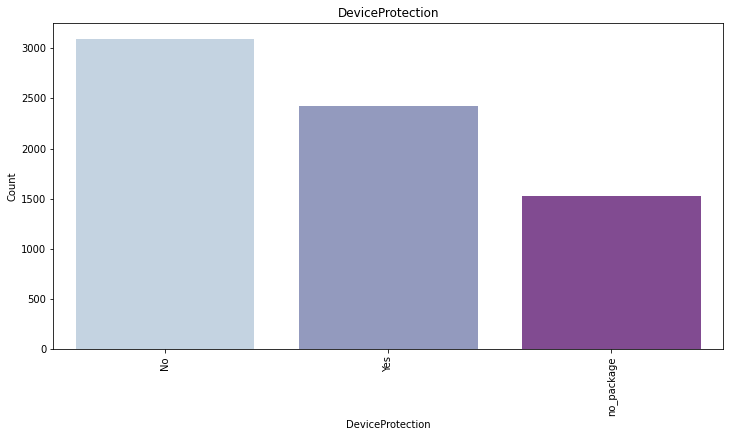

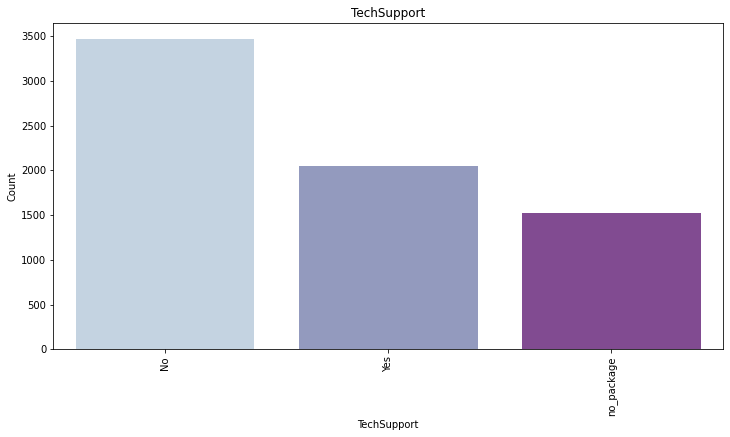

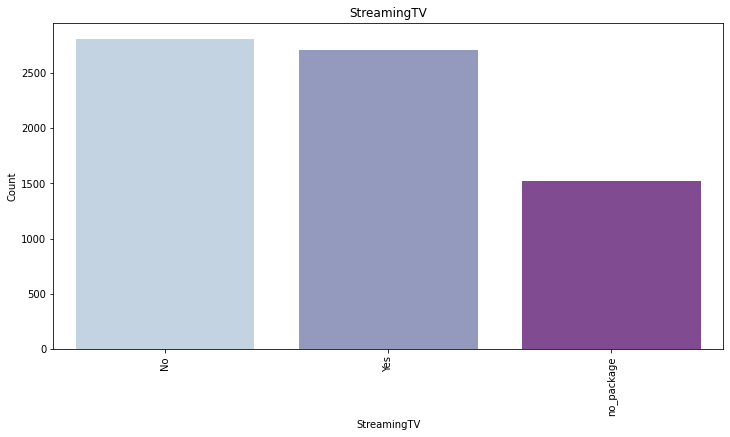

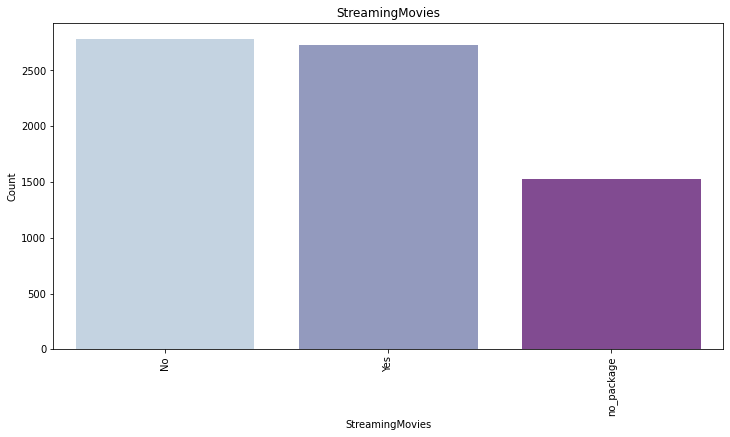

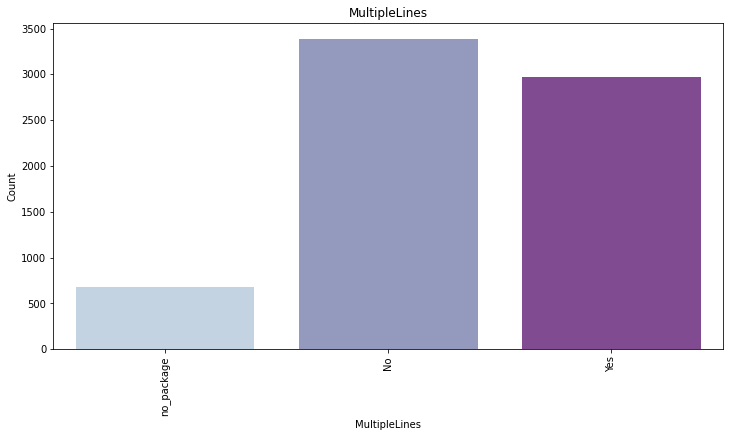

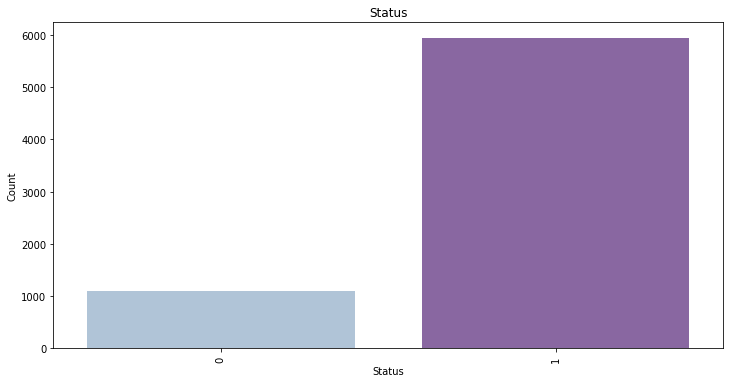

In [61]:
columns = data.select_dtypes(include='object').columns.tolist()
columns.remove('customerID')
columns.append('Status')
build_plots(data, columns)

### Вывод

Проанализируем графики:
* График срока жизни клиента показывает уменьшение с увеличением количества дней и резкий скачок в конце - у компании есть много долгосрочных клиентов;
* Частота людей с высокими общими расходами уменьшается;
* Большинство клиентов платят за услуги каждый месяц;
* Типы платежей разнообразны;
* Большинство клиентов не пользуется дополнительными услугами;
* В целевом признаке наблюдается дисбаланс классов - данных с текущими клиентами значительно больше, что может привести к смещению модели в сторону большинства. 

## Корреляционный анализ

In [62]:
data = data.drop(columns=['customerID'])

In [63]:
interval_cols = ['Lifetime', 'MonthlyCharges', 'TotalCharges']

Признаки Lifetime, MonthlyCharges и TotalCharges являются непрерывными количественными переменными, так как они могут принимать любые числовые значения в пределах определённого диапазона. Эти признаки необходимо включить в список непрерывных для дальнейшей обработки.

In [64]:
phik_matrix = data.phik_matrix(interval_cols=interval_cols)

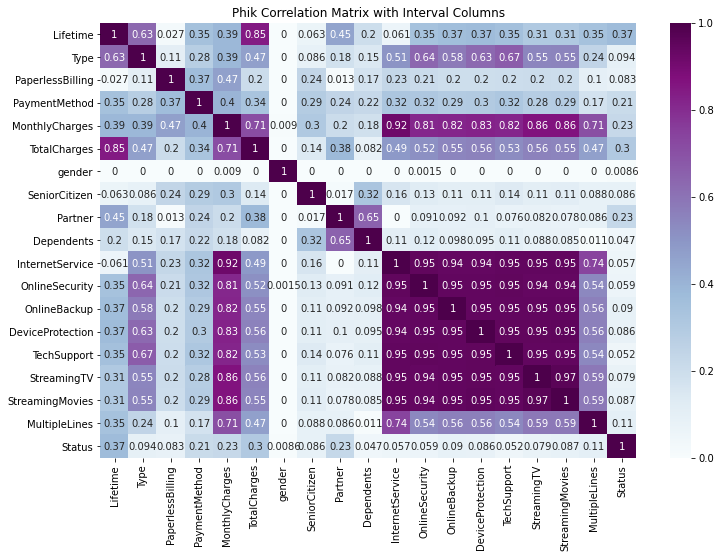

In [65]:
plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, cmap='BuPu', vmin=0, vmax=1)
plt.title('Phik Correlation Matrix with Interval Columns')
plt.show()

In [66]:
data = data.drop(['PaperlessBilling', 'gender', 'SeniorCitizen', 'TechSupport'], axis=1)

Удалим признаки, которые имеют низкую корреляцию с целевым признаком (-0.1 < x < 0.1)

## Подготовка данных

In [67]:
X = data.drop('Status', axis=1)
y = data['Status']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

In [69]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

In [70]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), 
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)  
    ])

In [71]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [72]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [73]:
X_train.shape, X_test.shape

((5282, 14), (1761, 14))

## Обучение моделей

### Random Forest

In [74]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

In [75]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'max_depth': [10, 20, 30],
}

In [76]:
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='roc_auc')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=141024),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [77]:
print(f'Лучшие параметры случайного леса: {grid_rf.best_params_}')
print(f'Лучшая метрика на кросс-валидации (ROC-AUC): {grid_rf.best_score_:.2f}')

Лучшие параметры случайного леса: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Лучшая метрика на кросс-валидации (ROC-AUC): 0.83


### CatBoost

In [78]:
cat_model = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)

In [79]:
param_grid_cat = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [80]:
grid_cat = GridSearchCV(cat_model, param_grid_cat, cv=5, scoring='roc_auc', n_jobs=-1)
grid_cat.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f988e7f3eb0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 300],
                         'learning_rate': [0.01, 0.1, 0.2]},
             scoring='roc_auc')

In [81]:
print(f'Лучшие параметры градиентного бустинга: {grid_cat.best_params_}')
print(f'Лучшая метрика на кросс-валидации (ROC-AUC): {grid_cat.best_score_:.2f}')

Лучшие параметры градиентного бустинга: {'depth': 4, 'iterations': 300, 'learning_rate': 0.2}
Лучшая метрика на кросс-валидации (ROC-AUC): 0.92


## Выбор лучшей модели

### Метрика на тестовой выборке

Градиентный бустинг показал хорошую метрику на кросс-валидации. Оценим модель на тестовой

In [82]:
cat_model = grid_cat.best_estimator_

In [83]:
y_pred_proba = cat_model.predict_proba(X_test)[:, 1]
y_pred = cat_model.predict(X_test)

In [84]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

In [85]:
print(f"ROC AUC: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")

ROC AUC: 0.93
Accuracy: 0.92


ROC AUC показывает, как хорошо модель различает классы. Значение 0.93 указывает на то, что модель способна правильно классифицировать 93% случаев.

Accuracy - доля правильных предсказаний среди всех. Значение 0.92 говорит о том, что 92% всех прогнозов модели совпадают с истинными значениями.

Модель демонстрирует высокую эффективность в прогнозировании оттока клиентов.

### Проверка модели на адекватность

In [86]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [87]:
y_prob_dummy = dummy_model.predict_proba(X_test)[:, 1]
roc_auc_dummy = roc_auc_score(y_test, y_prob_dummy)
print(f"ROC-AUC Dummy Model: {roc_auc_dummy:.2f}")

ROC-AUC Dummy Model: 0.50


In [88]:
if roc_auc > roc_auc_dummy:
    print("CatBoost превосходит константную")
else:
    print("CatBoost не лучше константной")

CatBoost превосходит константную


### ROC кривая

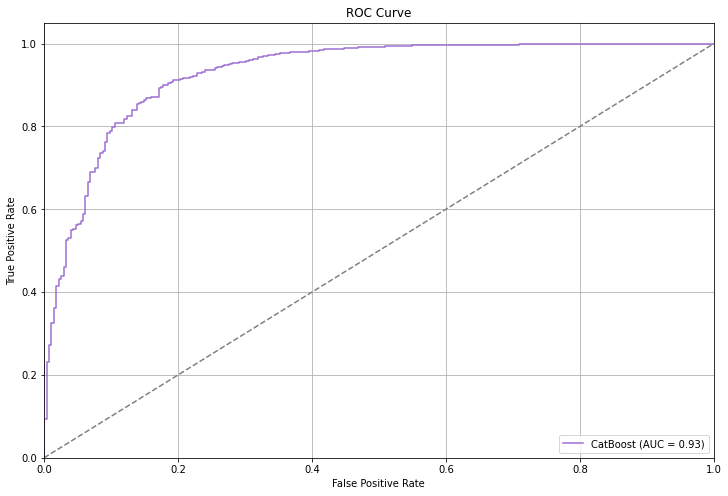

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})', color='#9d6ed4')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

ROC-кривая близка к верхнему левому углу, это означает, что модель хорошо отделяет положительные классы от отрицательных.

### Матрица ошибок

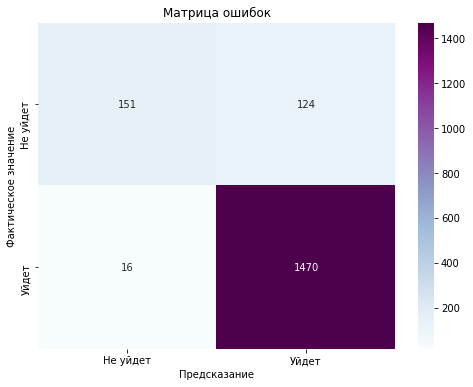

              precision    recall  f1-score   support

    Не уйдет       0.90      0.55      0.68       275
       Уйдет       0.92      0.99      0.95      1486

    accuracy                           0.92      1761
   macro avg       0.91      0.77      0.82      1761
weighted avg       0.92      0.92      0.91      1761



In [90]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=['Не уйдет', 'Уйдет'], yticklabels=['Не уйдет', 'Уйдет'])
plt.title('Матрица ошибок')
plt.xlabel('Предсказание')
plt.ylabel('Фактическое значение')
plt.show()

report = classification_report(y_test, y_pred, target_names=['Не уйдет', 'Уйдет'])
print(report)

__151 раз__ — количество True Positive (истинные положительные предсказания): модель правильно предсказала, что клиент останется в компании.

__124 раза__ — количество False Positive (ложные положительные предсказания): модель предсказала, что клиент останется, но он на самом деле ушёл (ошибочное удержание).

__16 раз__ — количество False Negative (ложные отрицательные предсказания): модель предсказала, что клиент уйдёт, но он остался (ошибочный уход).

__1470 раза__ — количество True Negative (истинные отрицательные предсказания): модель правильно предсказала, что клиент уйдёт из компании.

Итак, модель правильно предсказала количество клиентов, которые остались и ушли, что свидетельствует о ее эффективности. 
Однако достаточно большое количество клиентов, которые, как предполагала модель, уйдут, но на самом деле остались. Высокий уровень ложных срабатываний может привести к избыточным предложениям о промоакциях.

### Анализ важности признаков

In [91]:
feature_importances = cat_model.get_feature_importance()
feature_names = data.columns.tolist()[:-1]

In [92]:
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

In [93]:
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

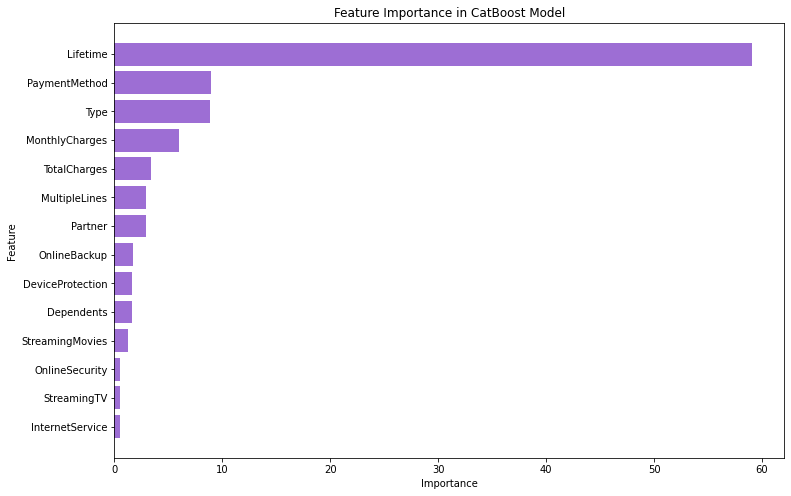

In [94]:
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='#9d6ed4')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

Признак __времени клиента в компании__ показывает, как долго клиент остаётся, и его высокая важность объясняется тем, что долгосрочные клиенты обычно менее склонны к уходу. __Периодичность платежей__ также имеет значительную важность, клиенты с ежегодными платежами могут быть более стабильными. __Тип платежа__ — это способ оплаты, удобные могут снижать вероятность оттока клиентов. Признаки __расходов__ указывают на финансовую вовлечённость клиента: клиенты с высокими расходами могут быть более заинтересованы в продолжении использования услуги.

## Вывод и рекомендации

В ходе проекта по предсказанию оттока клиентов оператора связи «ТелеДом» была проведена работа по обработке данных и обучению моделей. 

При подготовке данных были заполнены пропуски, изменены типы данных. Целевой признак сформирован самостоятельно - на основе даты окончания контракта.

После объединения датафреймов, был проведен исследовательский и корреляционный анализ. В ходе него удалены ненужные признаки и сформирован новый - продолжительность контракта. Перед обучением данные были кодированы и масштабированы в пайплайне.

Обучение проводилось на двух моделях: Random Forest и CatBoost. Обе модели были настроены с использованием Grid Search для оптимизации гиперпараметров. В качестве лучшей модели был выбран градиентный бустинг (ROC AUC 0.91 на кросс-валидации). 

CatBoost использовался для предсказания на тестовой выборке. Метрики: ROC AUC (0.93) и Accuracy (0.93), что свидетельствует о хорошей предсказательной способности моделей. Также проанализирована матрица ошибок и ROC-кривая.

Следует продолжать мониторинг оттока клиентов и использовать разработанную модель для выявления клиентов, находящихся под угрозой ухода. Важно также рассмотреть возможность внедрения дополнительных промоакций для таких клиентов, чтобы повысить уровень удержания. Следует периодически обновлять данные и переобучать модели для обеспечения актуальности предсказаний.